In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from torchinfo import summary

#from helper_functions import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 7.0)

from helper_torch import *

In [2]:
class Conv_Bi_LSTM(nn.Module):
    def __init__(self, nfeat_x, nfeat_y, window_in, window_out):
        super().__init__()
        self.bilstm1 = nn.LSTM(input_size=nfeat_x, hidden_size=128, batch_first=True, bidirectional=True, dropout=0.5)
        self.conv1 = nn.Conv1d(in_channels=7, out_channels=7, kernel_size=64)
        self.bilstm2 = nn.LSTM(input_size=(256 -63), hidden_size=256, batch_first=True, bidirectional=True, dropout=0.5)
        self.conv2 = nn.Conv1d(in_channels=7, out_channels=7, kernel_size=128)
        self.bilstm3 = nn.LSTM(input_size=(256*2 - 127), hidden_size=128, batch_first=True, bidirectional=True, dropout=0.5)
        self.conv3=nn.Conv1d(in_channels=7, out_channels=7, kernel_size=64)
        self.relu = nn.ReLU()
        self.selu = nn.SELU()
        self.fc = nn.Linear(window_in * 193, nfeat_y * window_out)

        self.yfeat = nfeat_y
        self.xfeat = nfeat_x
        self.win_in = window_in
        self.win_out = window_out

    def forward(self, x):
        #print('x.shape: ', x.shape)
        x, _ = self.bilstm1(x)
        #print('bilstm1: ', x.shape)
        x = self.conv1(x)
        x = self.selu(x)
        #print('conv1 ',x.shape)
        x, _ = self.bilstm2(x)
        #print('bilstm2', x.shape)
        x = self.conv2(x)
        #print('conv2: ', x.shape)
        x = self.selu(x)
        x, _ = self.bilstm3(x)
        #print('bisltm3:', x.shape)
        x = self.conv3(x)
        x = self.relu(x)
        #print('conv3: ', x.shape)
        x = x.reshape((x.shape[0], -1))
        #print("x.reshape: ", x.shape)
        x = self.fc(x)
        #print('fc: ', x.shape)
        y = x.reshape((x.shape[0], self.win_out, self.yfeat))
        #print('final', y.shape)

        
        return y





In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
window_in = 7
window_out = 1
colsx = ['Cumulative True Cases','Free','Positively Tested','CR', 'Series_No']
colsy = ['Cumulative True Cases','Free','Positively Tested', 'Series_No']
input_shape = (window_in, len(colsx) - 1)
train_seq, test_seq, len_of_ser, num_windows_ser, x_test, y_true = preprocess(dataframe_csvpath = "data.csv", 
    cols_x = colsx, 
    cols_y = colsy, 
    window_in = window_in, 
    window_out = window_out, 
    data_div_frac = 0.99, 
    popu_size = 80000
)

c:\Users\matha\Desktop\TSE_SIR\helper_torch.py:114: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(train_seq), np.array(test_seq), len_ser, win_len_per_ser, np.array(x_test), np.array(y_true)


In [5]:
model = Conv_Bi_LSTM(nfeat_x=len(colsx)-1, nfeat_y=len(colsy)-1, window_in=window_in, window_out=window_out).to(device=device)
summary(model, (1,7,4))


C:\Users\matha\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Output Shape              Param #
Conv_Bi_LSTM                             --                        --
├─LSTM: 1-1                              [1, 7, 256]               137,216
├─Conv1d: 1-2                            [1, 7, 193]               3,143
├─SELU: 1-3                              [1, 7, 193]               --
├─LSTM: 1-4                              [1, 7, 512]               923,648
├─Conv1d: 1-5                            [1, 7, 385]               6,279
├─SELU: 1-6                              [1, 7, 385]               --
├─LSTM: 1-7                              [1, 7, 256]               527,360
├─Conv1d: 1-8                            [1, 7, 193]               3,143
├─ReLU: 1-9                              [1, 7, 193]               --
├─Linear: 1-10                           [1, 3]                    4,056
Total params: 1,604,845
Trainable params: 1,604,845
Non-trainable params: 0
Total mult-adds (M): 14.75
Input size (MB): 0.00
For

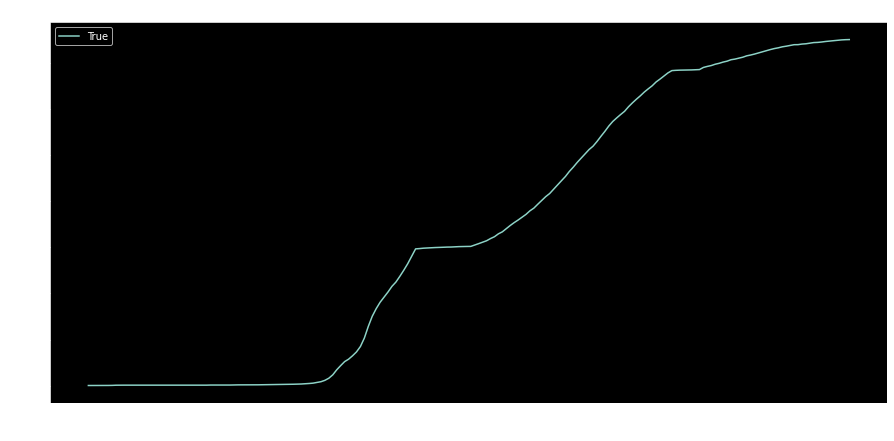

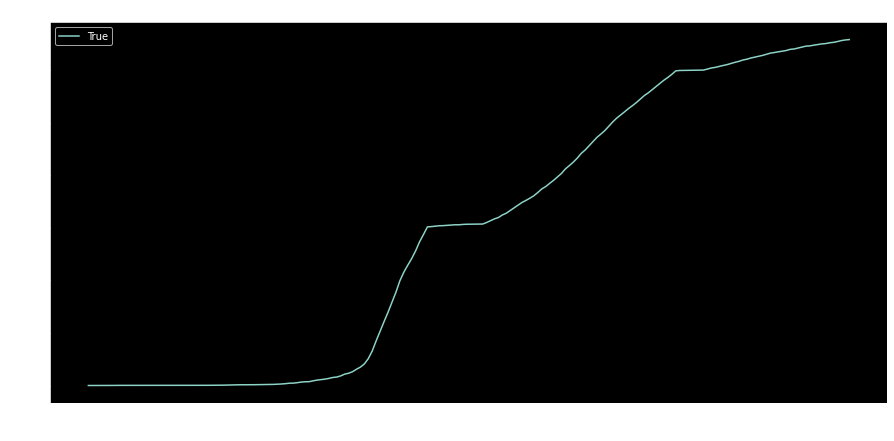

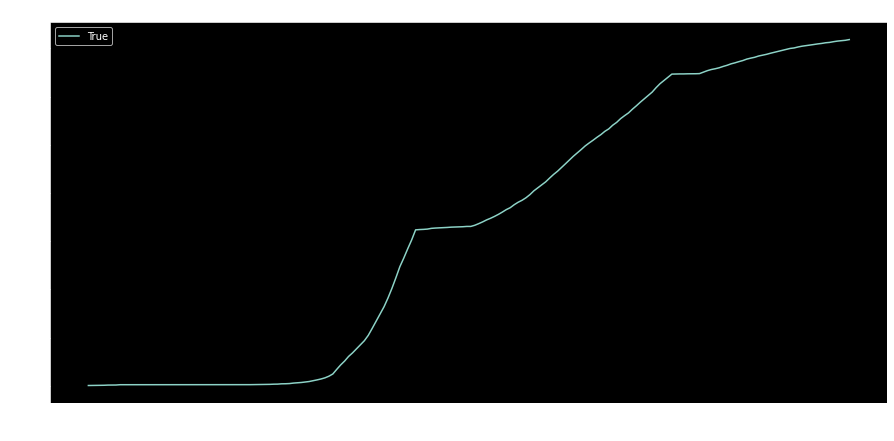

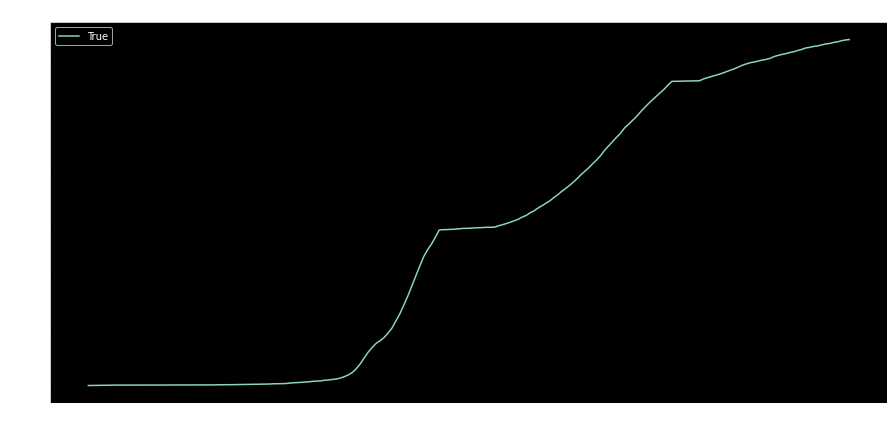

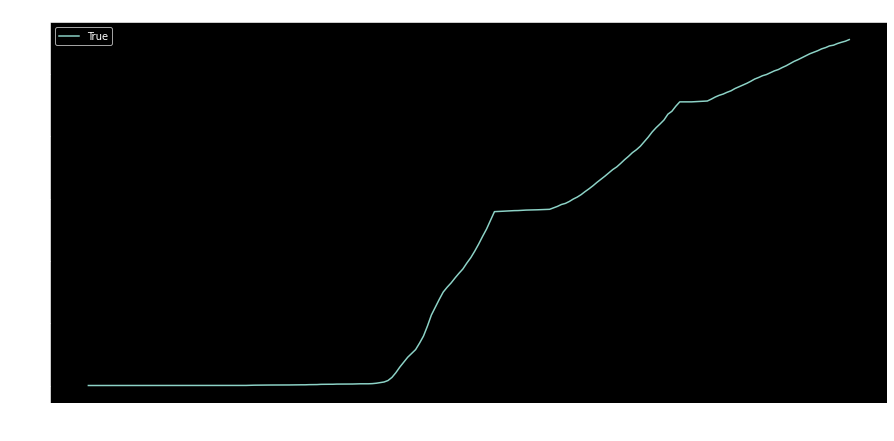

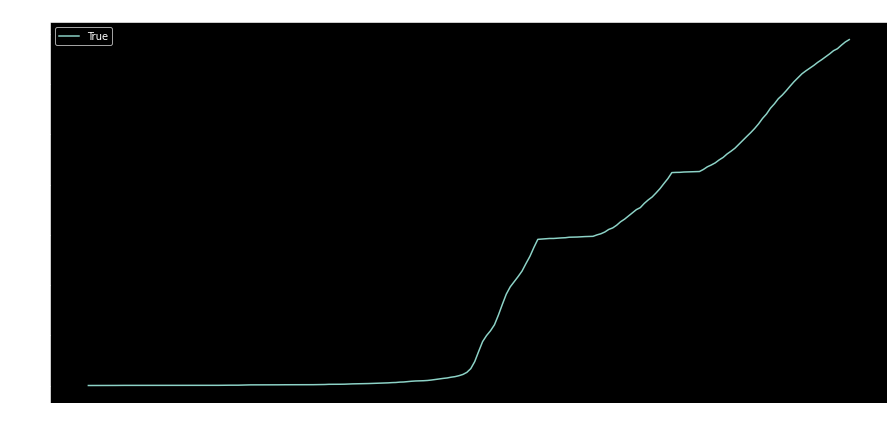

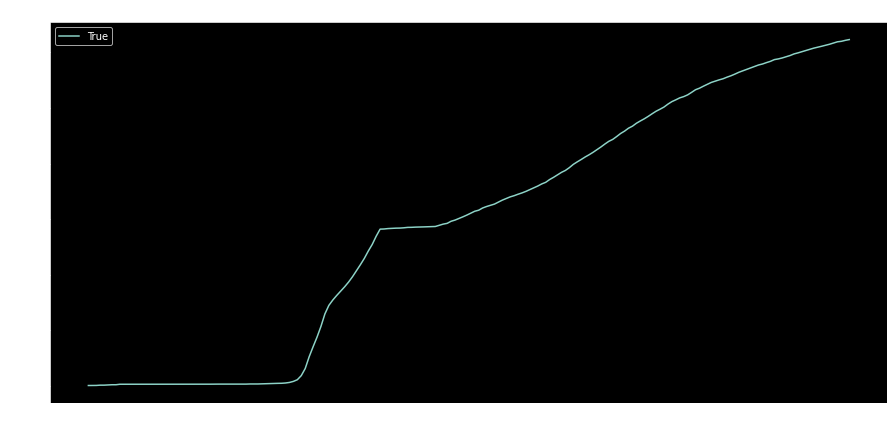

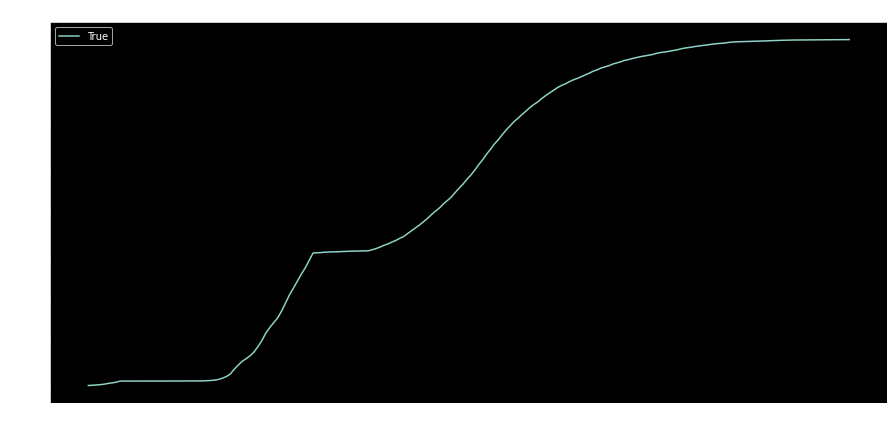

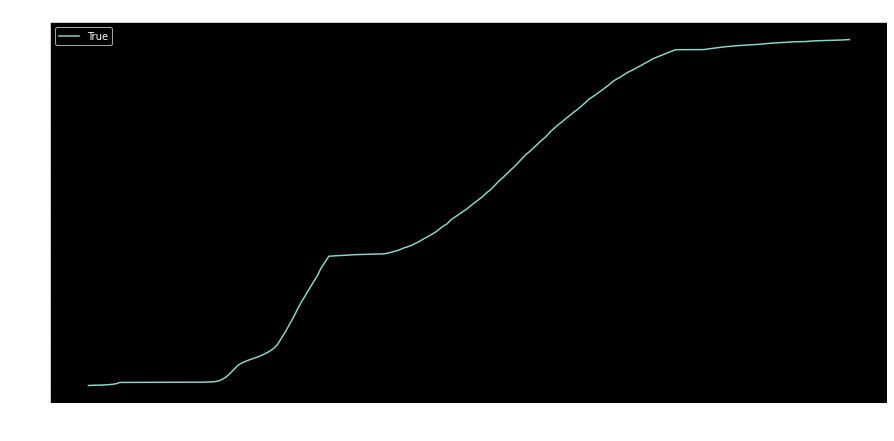

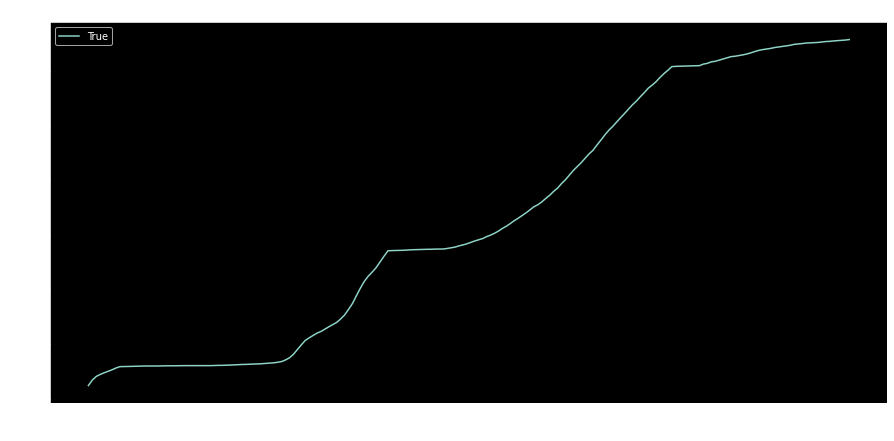

In [6]:
visualize_data(y_test=y_true, x_test=x_test, window_out=window_out, num_plots=10, num_win_ser=num_windows_ser, cols_y=colsy, col_idx=0)

In [7]:
train_seq_obj = TSD(train_seq)
test_seq_obj = TSD(test_seq)

In [8]:
criterion = nn.L1Loss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [9]:
train_loader = DataLoader(dataset=train_seq_obj, batch_size=num_windows_ser, shuffle=False)
test_loader = DataLoader(dataset=test_seq_obj, batch_size=num_windows_ser, shuffle=False) #always same batch_size

In [11]:
num_epochs = 60
model.train().to(device)
arr_loss = []
for epoch in range(num_epochs):
    
    for idx, (ser, targets) in enumerate(train_loader):

        optimizer.zero_grad()

        ser = ser.float().to(device)
        targets = targets.float().to(device)
        #print(ser.shape)
        #print(targets.shape)
        pred = model(ser)
        #print(pred.shape)
        loss = criterion(pred, targets)
        
        loss.backward()
        optimizer.step()
        
    arr_loss.append(loss.item())

    print(f'epoch: {epoch + 1}  |  loss: {loss: 5f}')


epoch: 1  |  loss:  0.922664
epoch: 2  |  loss:  0.847454
epoch: 3  |  loss:  0.503866
epoch: 4  |  loss:  1.249763
epoch: 5  |  loss:  0.555912
epoch: 6  |  loss:  0.315929
epoch: 7  |  loss:  0.609754
epoch: 8  |  loss:  0.314031
epoch: 9  |  loss:  0.175333
epoch: 10  |  loss:  0.326288
epoch: 11  |  loss:  0.375680
epoch: 12  |  loss:  0.217255
epoch: 13  |  loss:  0.382623
epoch: 14  |  loss:  0.457644
epoch: 15  |  loss:  0.226134
epoch: 16  |  loss:  0.444049
epoch: 17  |  loss:  0.125377
epoch: 18  |  loss:  0.251868
epoch: 19  |  loss:  0.370092
epoch: 20  |  loss:  0.213244
epoch: 21  |  loss:  0.267274
epoch: 22  |  loss:  0.241691
epoch: 23  |  loss:  0.178468
epoch: 24  |  loss:  0.175245
epoch: 25  |  loss:  0.286130
epoch: 26  |  loss:  0.510527
epoch: 27  |  loss:  0.194783
epoch: 28  |  loss:  0.138440
epoch: 29  |  loss:  0.130456
epoch: 30  |  loss:  0.367040
epoch: 31  |  loss:  0.255394
epoch: 32  |  loss:  0.173203
epoch: 33  |  loss:  0.296018
epoch: 34  |  loss:

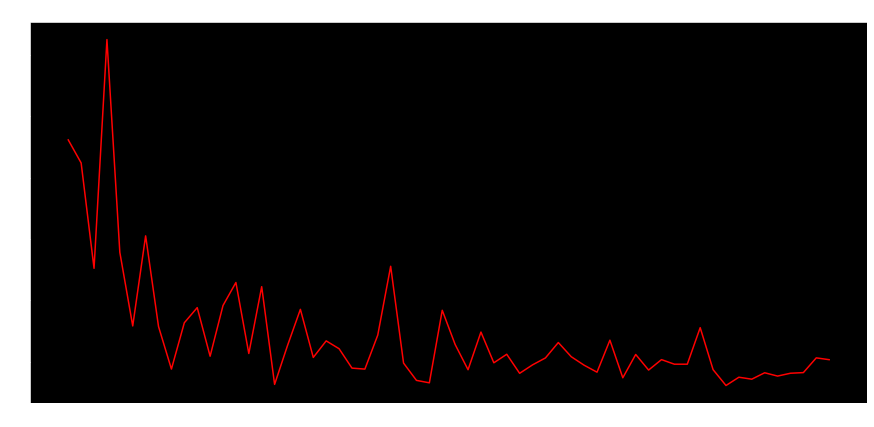

In [15]:
plt.plot(arr_loss, color='red')
plt.title("loss per epoch")
plt.show()

In [20]:
def predictions(loader, model, win_len_per_ser, criterion,  device, window_out = 1 ):
    """
    Makes Predictions for time series data using the model trained.   
    
    Arguments:
    x_test, y_test -- Testing data
    model -- Model trained previously
    len_seq -- The length of days in a paricular time-series
    window_in -- The input window size for the model
    window_out -- The predicted window size of model
    
    
    Returns:  
    y_pred -- The predicted windows (for plotting)
    mae -- Mean absolute Error of y_pred and y_true
    
    """
  
    model.eval()
    num_win_per_ser = win_len_per_ser   #num windows
    #print(num_win_per_ser)
    y_pred = []
    y_true = []
    with torch.no_grad():
        for idx, (x, y) in enumerate(loader):  #for i in range(0, len(y_test), num_win_per_ser): # i takes index values of first windows of different series
            
            win_start = torch.tensor(x[0]).float().to(device) # saving the first window of each series
            #print('win_start:', win_start)
            CR = win_start[0][3] # saving the CR value for particular series -> to be used for prediction
            #print('CR:', CR)
            win = win_start # window variable which will be updated for new windows, takes first value as the starting window
            #print(win)
            win = win.reshape((1, win.shape[0], win.shape[1]))
            #print(win.shape)
            for j in range(num_win_per_ser): # prediction loop 
                y_hat = model(win) # predicting values wrt win variable
                #print('y_hat ', y_hat)  
                y_pred.append(y_hat[0].cpu().detach().numpy()) # add the value to y_pred
                #print('y_pred:', y_pred)
                y_true.append(y[j].cpu().detach().numpy()) # add the value to y_pred
                #print('y_true:', y_true)
                cr_dummy = torch.empty((1, window_out, 1), dtype=torch.float32).to(device)
                y_hat = torch.cat((y_hat, cr_dummy.fill_(float(CR))), 2).float()
                #y_hat = tf.concat([y_hat, tf.fill(dims = (1, window_out, 1), value = CR)], axis = 2) # adding CR value y_hat for furter predictions
                #print('cr added to y_hat', y_hat)   
                win = torch.cat((win, y_hat), 1)
                #win = tf.concat([win, y_hat], axis = 1) # adding our prediction to win
                #print('win', win)
                win = win[:,window_out:,:] # updating win by removing the starting elements
                #print('new_win for next iter', win)

    
        y_pred = torch.tensor(y_pred).to(device)
        y_true = torch.tensor(y_true).to(device)
        assert (y_pred.shape == y_true.shape)

        mae = criterion(y_pred, y_true)
        #mae = tf.reduce_sum(tf.keras.metrics.mean_absolute_error(y_pred, y_test))
        print(f'The error is: " {mae: .5f}')

    model.train()
    return y_pred.cpu().detach().numpy(), y_true.cpu().detach().numpy(), mae.cpu().detach().numpy()

In [21]:
y_pred, y_true, mae = predictions(loader=test_loader, model = model, win_len_per_ser=num_windows_ser, criterion=criterion, device=device, window_out=window_out)

C:\Users\matha\AppData\Local\Temp/ipykernel_15624/883245586.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  win_start = torch.tensor(x[0]).float().to(device) # saving the first window of each series


The error is: "  141.35088


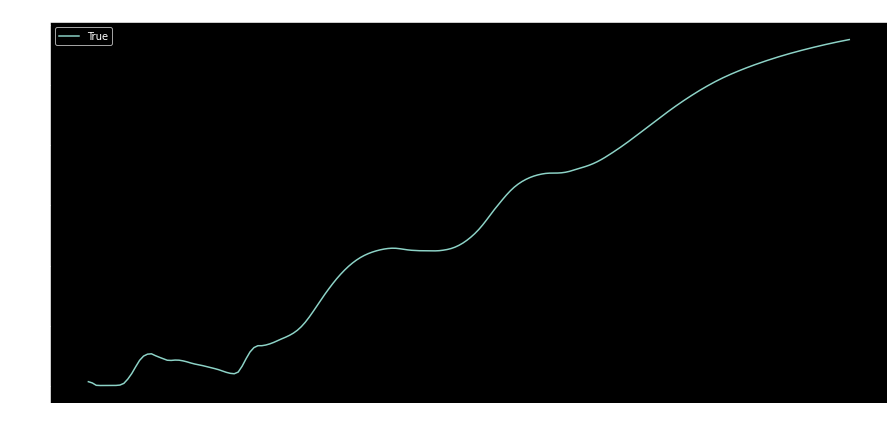

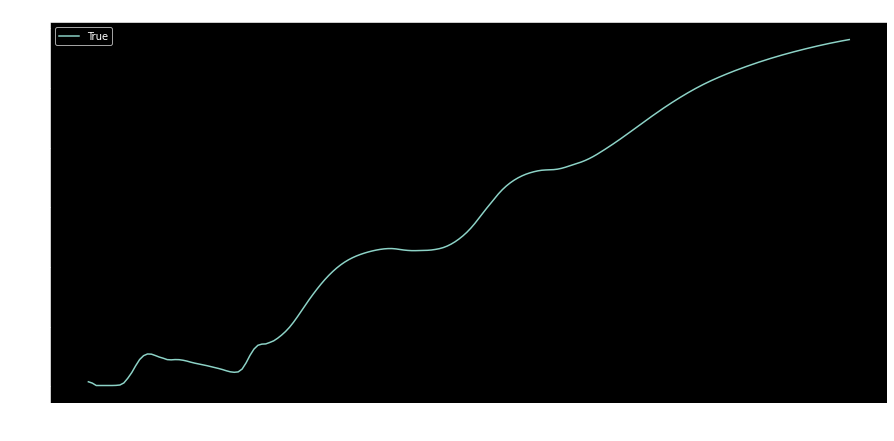

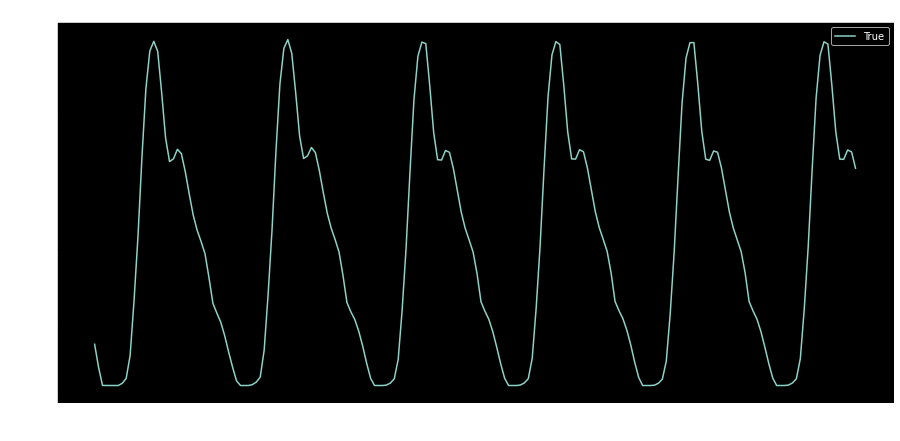

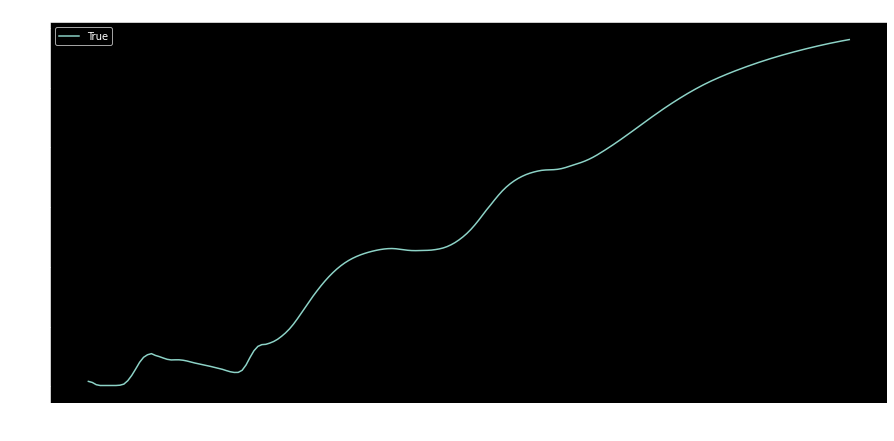

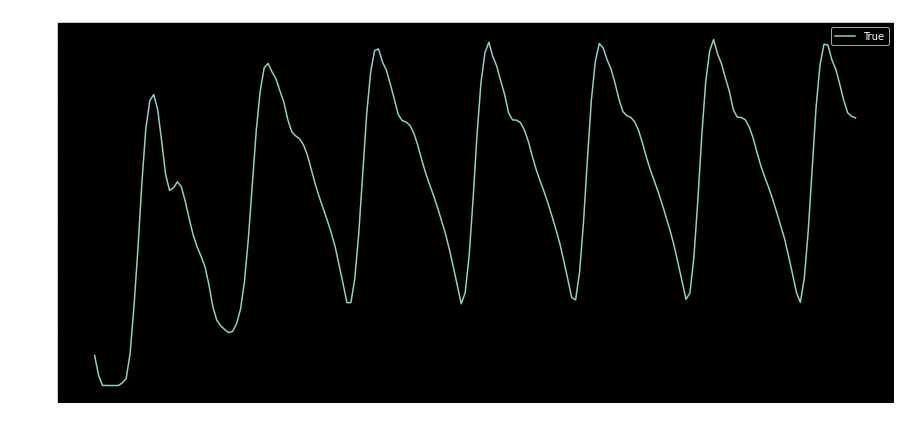

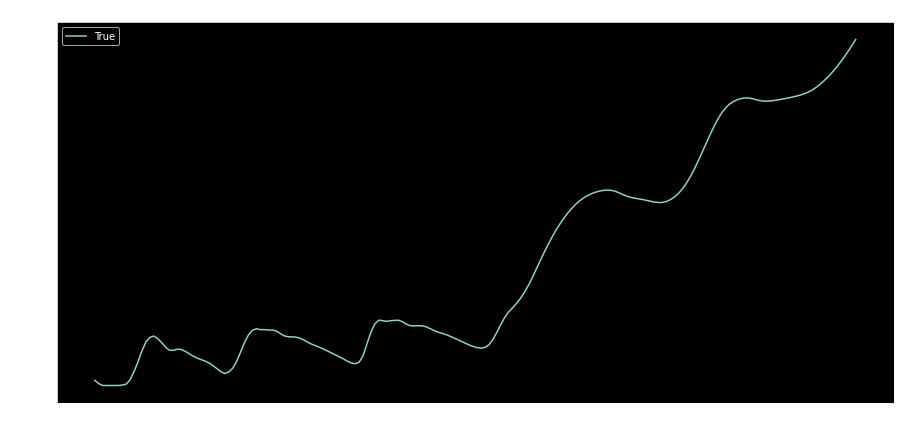

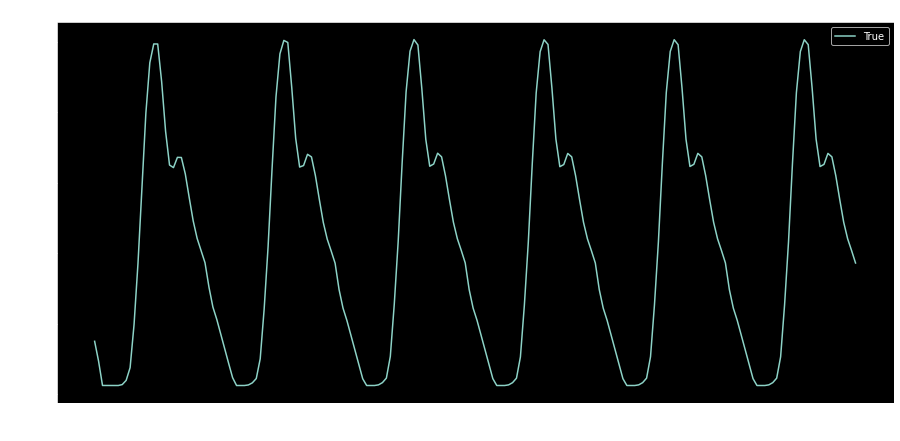

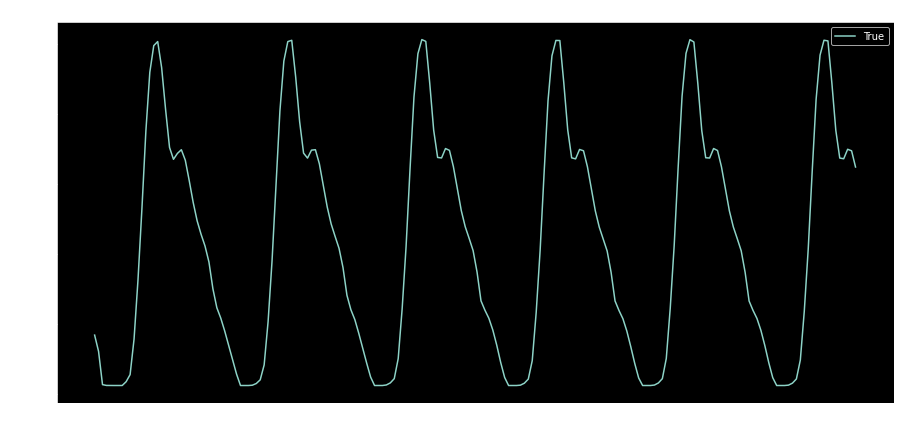

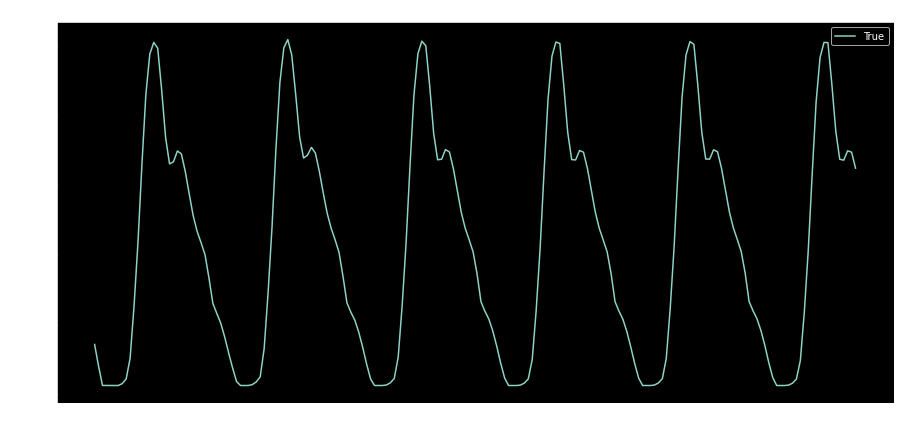

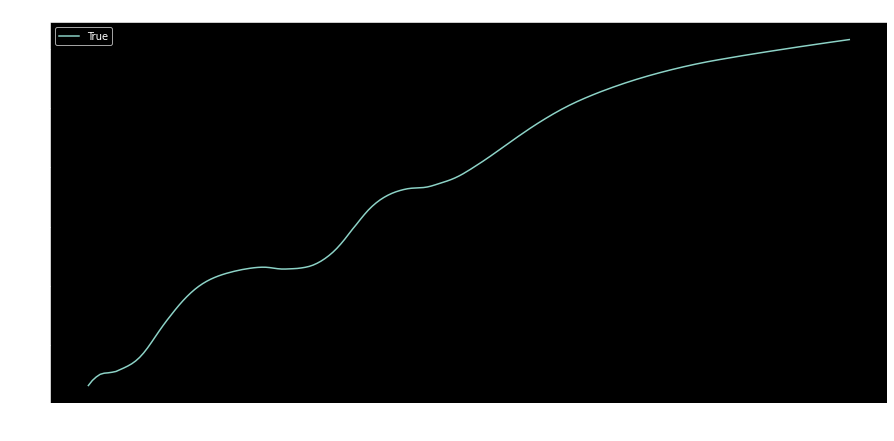

In [22]:
visualize_data(y_test=y_pred, x_test=x_test, window_out=window_out, num_plots=10, num_win_ser=num_windows_ser, cols_y=colsy, col_idx=0)

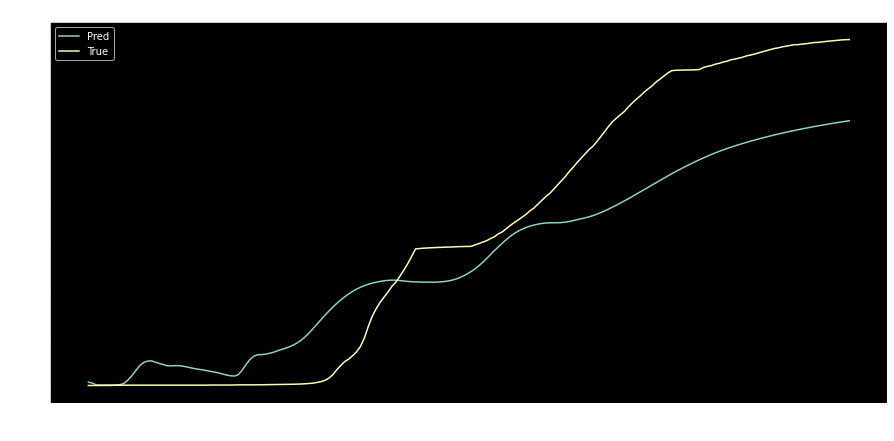

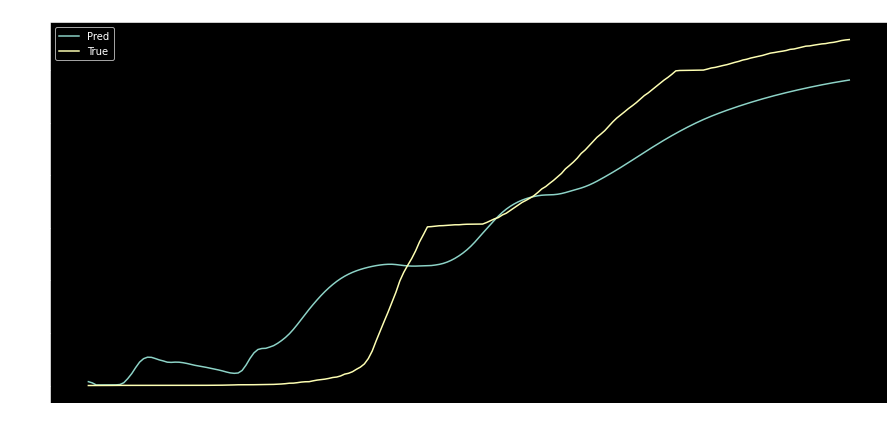

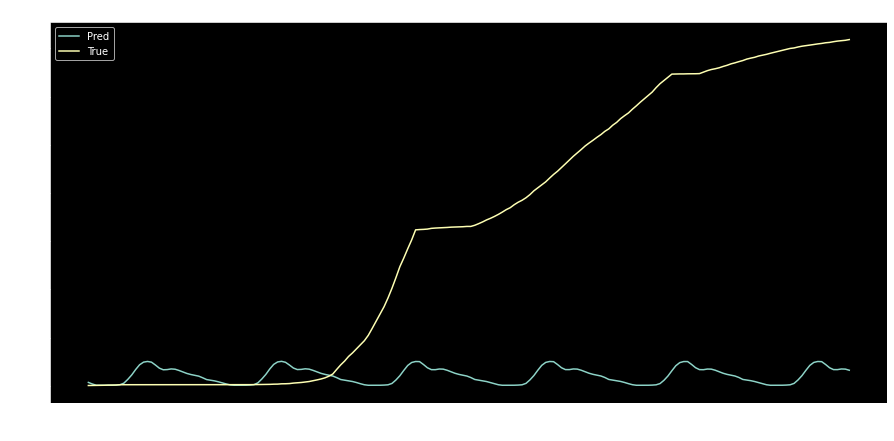

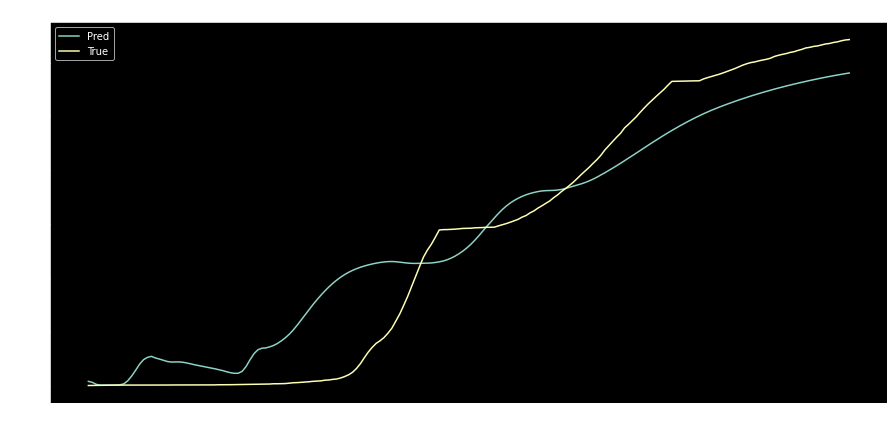

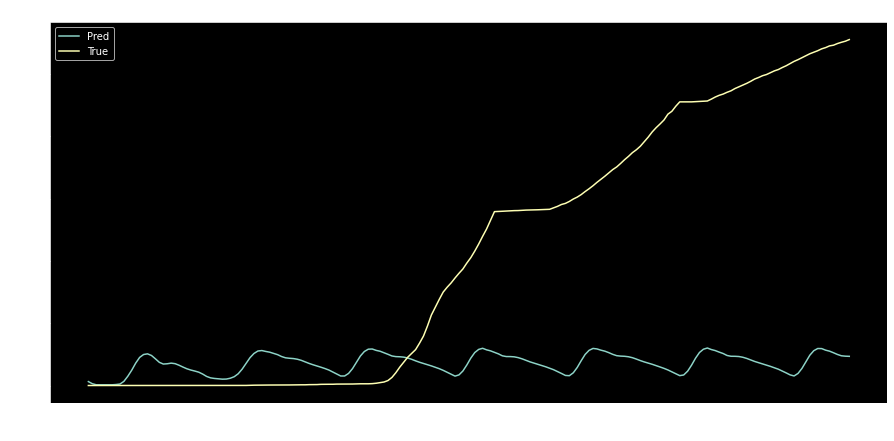

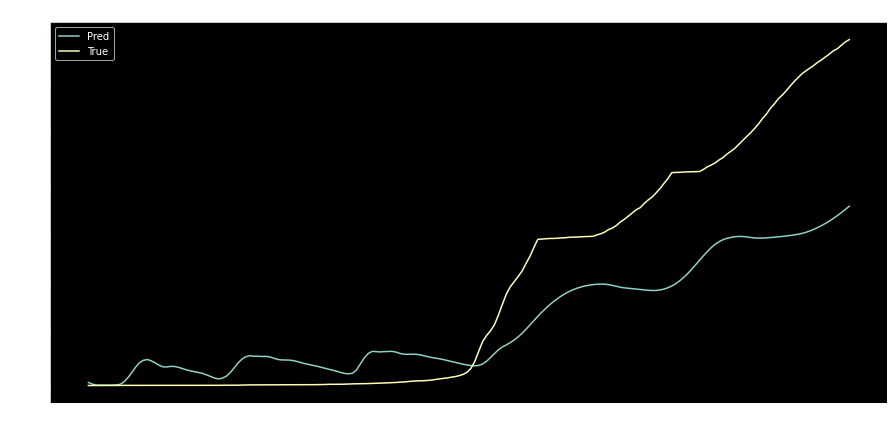

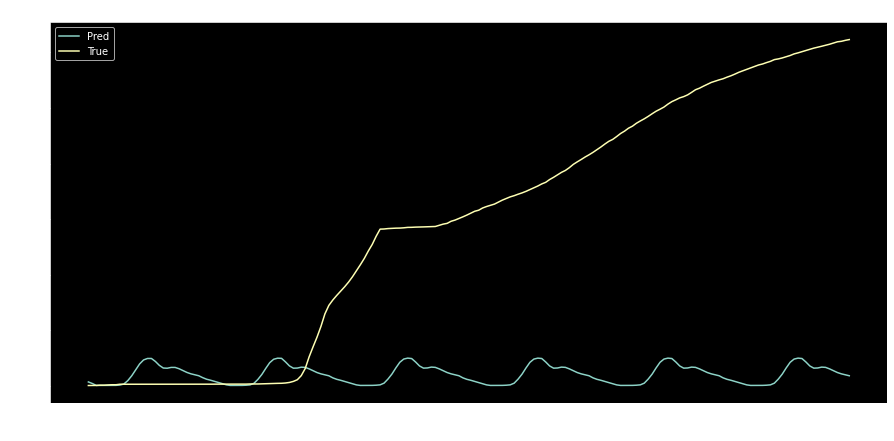

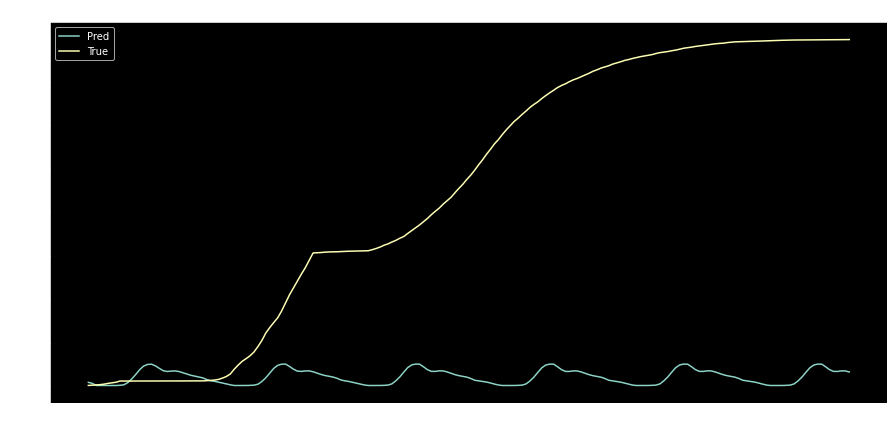

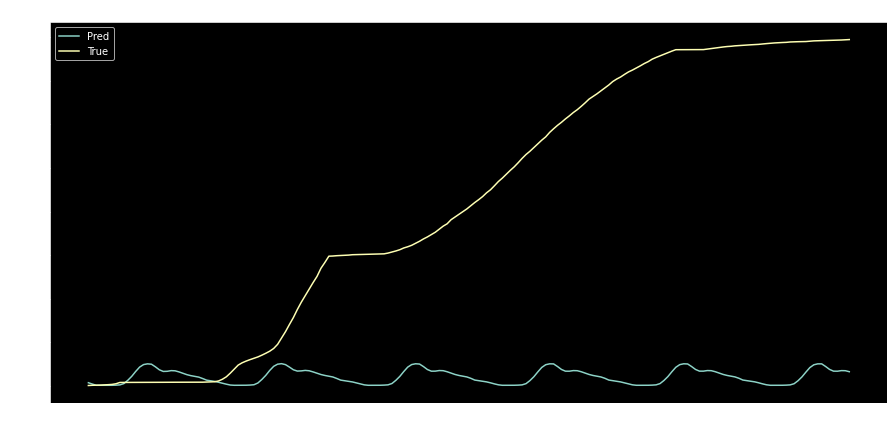

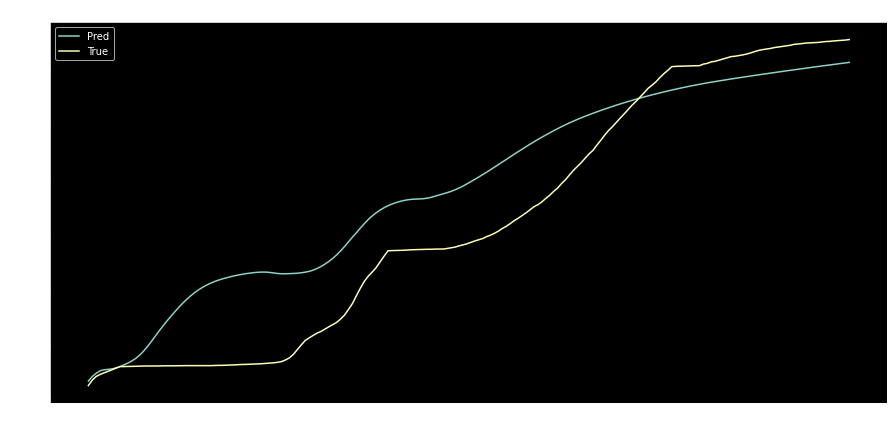

In [23]:
visualize_pred(y_test=y_true, y_pred=y_pred, test_seq=test_seq, window_out=window_out, num_plots=10, num_win_ser=num_windows_ser, cols_y=colsy, col_idx=0)